In [1]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt

np.set_printoptions(threshold=np.inf)

cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


In [2]:
def ConvBNRelu(x,channel,kernel_size,strides,padding):
    #所有调用tf的层全部在层函数后面用（x）传入张量
    x=tf.keras.layers.Conv2D(channel,kernel_size,strides=strides,padding=padding)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.Activation('relu')(x)
    return x

In [3]:
def inception_block(x,channel,strides):
    x1=ConvBNRelu(x,channel=channel,kernel_size=1,strides=strides,padding='same')

    x2_1=ConvBNRelu(x,channel=channel,kernel_size=1,strides=strides,padding='same')
    x2_2=ConvBNRelu(x2_1,channel=channel,kernel_size=3,strides=1,padding='same')

    x3_1=ConvBNRelu(x,channel=channel,kernel_size=1,strides=strides,padding='same')
    x3_2=ConvBNRelu(x3_1,channel=channel,kernel_size=5,strides=1,padding='same')

    x4_1=tf.keras.layers.MaxPool2D(3,strides=1,padding='same')(x)
    x4_2=ConvBNRelu(x4_1,channel=channel,kernel_size=1,strides=strides,padding='same')

    x=tf.concat([x1,x2_2,x3_2,x4_2],axis=3)
    return x

In [4]:
def inception10(blocks_num,classes_num,init_ch=16):
    input=tf.keras.Input(shape=(None,None,3))#明确输入的尺寸
    x=ConvBNRelu(input,init_ch,kernel_size=3,strides=1,padding='same')

    out_channels=init_ch
    for block_id in range(blocks_num):
        for layer_id in range(2):
            if layer_id==0:
                x=inception_block(x,channel=out_channels,strides=2)
            else:
                x=inception_block(x,channel=out_channels,strides=1)
        out_channels*=2

    x=tf.keras.layers.GlobalAveragePooling2D()(x)
    output=tf.keras.layers.Dense(classes_num,activation='softmax')(x)
    model=tf.keras.Model(input,output)#建立model类，方便下面用八股训练
    return model
    

In [10]:
model = inception10(blocks_num=2,classes_num=10)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

checkpoint_save_path = "./checkpoint/Baseline.ckpt"

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])
model.summary()

782/782 [==============================] - 18s 20ms/step - loss: 1.2899 - sparse_categorical_accuracy: 0.5351 - val_loss: 1.2968 - val_sparse_categorical_accuracy: 0.5393
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   448         ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 batch_normalization (

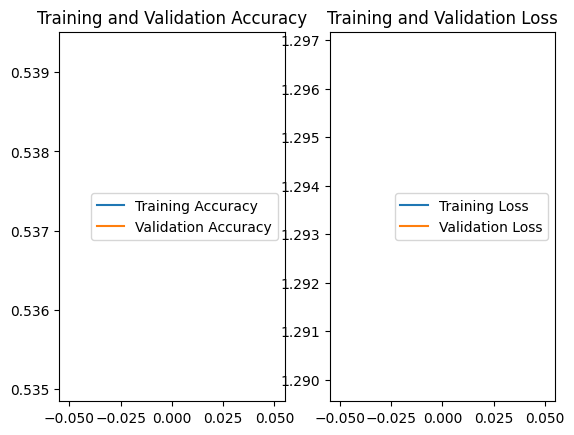

In [11]:
# 显示训练集和验证集的acc和loss曲线
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [12]:
tf.keras.backend.get_session().close()

AttributeError: module 'keras.api._v2.keras.backend' has no attribute 'get_session'